In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu118
True


In [3]:
class CSVDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, dtype="train"):
        self.data = pd.read_csv(data_path)
        self.dtype = dtype
        if self.dtype == "test":
            self.ids = self.data['INDEX'].values
            self.features = self.data[['F1', 'F2', 'F3']].values  
        else:
            self.features = self.data[['F1', 'F2', 'F3']].values  
            self.labels = self.data['OUT'].values  
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.dtype == "test":
            features = torch.tensor(self.features[idx], dtype=torch.float32)
            return self.ids[idx], features
        else:
            features = torch.tensor(self.features[idx], dtype=torch.float32)
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return features, label

In [5]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

PATH = '' 
dataset = CSVDataset(PATH + 'kaggle_1_train.csv')

testing_dataset = CSVDataset(PATH + 'kaggle_1_test.csv', "test")

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

full_train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=128)

c:\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


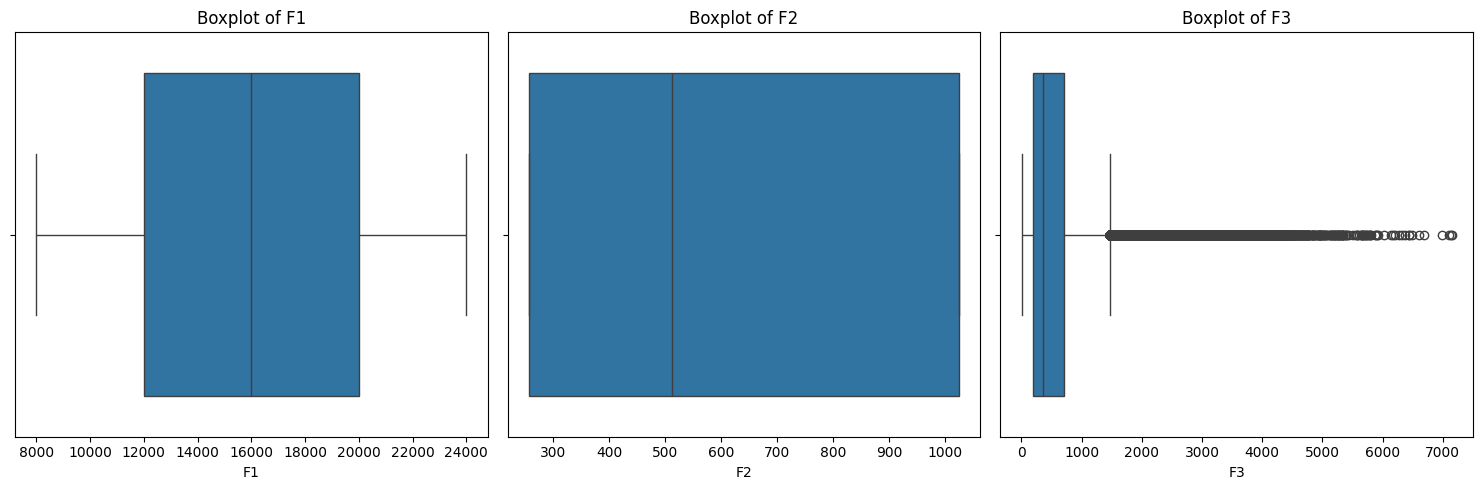

c:\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


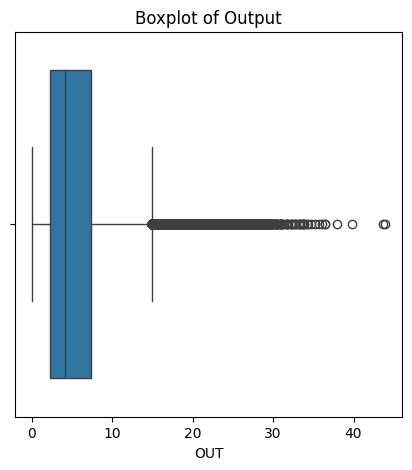

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# For features
plt.figure(figsize=(15, 5))
for i, col in enumerate(['F1', 'F2', 'F3']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=dataset.data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# For output
plt.figure(figsize=(5, 5))
sns.boxplot(x=dataset.data['OUT'])
plt.title('Boxplot of Output')
plt.show()

In [67]:
def init_weights_he(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.0)

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        # Using Xavier Uniform initialization
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

def init_weights_orthogonal(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


In [68]:
class MyModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Enhanced Wide Path (Feature Interactions)
        self.wide = nn.Sequential(
            nn.Linear(input_dim, 146),
            # nn.LayerNorm(128),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(146, 292),
            # 
        )
        
        # Enhanced Deep Path
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),

            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.SiLU()
            
        )
        
        # Attention-based Fusion
        self.attention = nn.MultiheadAttention(embed_dim=16+292, num_heads=4)
        
        # Final Predictor
        self.final = nn.Sequential(
            nn.Linear(16+292, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        wide = self.wide(x)
        deep = self.deep(x)
        combined = torch.cat([deep, wide], dim=1)
        
        # Apply attention to combined features
        attn_out, _ = self.attention(combined.unsqueeze(0), combined.unsqueeze(0), combined.unsqueeze(0))
        attn_out = attn_out.squeeze(0)
        
        return self.final(0.6 * combined + 0.4 * attn_out)

In [69]:
# class WeightedLoss(nn.Module):
#     def __init__(self, mse_weight=0.9, mae_weight=0.1):
#         super(WeightedLoss, self).__init__()
#         self.mse_weight = mse_weight
#         self.mae_weight = mae_weight
#         self.mse_loss = nn.MSELoss()
#         self.mae_loss = nn.L1Loss()  # L1Loss is equivalent to MAE

#     def forward(self, outputs, targets):
#         mse = self.mse_loss(outputs, targets)
#         mae = self.mae_loss(outputs, targets)
#         return self.mse_weight * mse + self.mae_weight * mae

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = dataset.features.shape[1]
print(input_dim)
model = MyModel(input_dim)
model = model.to(device)


model.apply(init_weights_orthogonal)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

num_epochs = 100

best_val_mse = float('inf')
best_model_path = 'best_model.pt'

Using device: cuda
3


In [71]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_total = 0.0
    total_train_samples = 0
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features).squeeze() 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item() * features.size(0)
        total_train_samples += features.size(0)
        
    train_mse = train_loss_total / total_train_samples
    
    model.eval()
    val_loss_total = 0.0
    total_val_samples = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * features.size(0)
            total_val_samples += features.size(0)
    
    val_mse = val_loss_total / total_val_samples
    print(f'Epoch {epoch}/{num_epochs} - Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}')
    
    # Update the scheduler with the validation MSE
    scheduler.step(val_mse)
    
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        torch.save(model.state_dict(), best_model_path)
        print(f'-- New best model saved with Validation MSE: {best_val_mse:.4f}')


Epoch 1/100 - Train MSE: 5.8073, Validation MSE: 4.3826
-- New best model saved with Validation MSE: 4.3826
Epoch 2/100 - Train MSE: 4.2888, Validation MSE: 4.4327
Epoch 3/100 - Train MSE: 4.2053, Validation MSE: 4.2344
-- New best model saved with Validation MSE: 4.2344
Epoch 4/100 - Train MSE: 4.1827, Validation MSE: 4.5303
Epoch 5/100 - Train MSE: 4.1767, Validation MSE: 4.2711
Epoch 6/100 - Train MSE: 4.1652, Validation MSE: 4.2640
Epoch 7/100 - Train MSE: 4.1522, Validation MSE: 4.2135
-- New best model saved with Validation MSE: 4.2135
Epoch 8/100 - Train MSE: 4.1546, Validation MSE: 4.3536
Epoch 9/100 - Train MSE: 4.1478, Validation MSE: 4.2630
Epoch 10/100 - Train MSE: 4.1303, Validation MSE: 4.2036
-- New best model saved with Validation MSE: 4.2036
Epoch 11/100 - Train MSE: 4.1256, Validation MSE: 4.2455
Epoch 12/100 - Train MSE: 4.1259, Validation MSE: 4.1973
-- New best model saved with Validation MSE: 4.1973
Epoch 13/100 - Train MSE: 4.1280, Validation MSE: 4.2103
Epoch 14

In [72]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

ids_all = []
predictions = []
with torch.no_grad():
    for ids, features in test_loader:
        features = features.to(device)
        outputs = model(features).squeeze()
        predictions.extend(outputs.cpu().numpy().tolist())
        if isinstance(ids, torch.Tensor):
            ids_all.extend(ids.cpu().numpy().tolist())
        else:
            ids_all.extend(ids)

output_df = pd.DataFrame({
    "ID": ids_all,
    "OUT": predictions
})

output_csv_path = "predictions.csv"
output_df.to_csv(output_csv_path, index=False)